In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt



pd.options.mode.chained_assignment = None  # default='warn'

sys.path.insert(1, '/mnt/c/Users/Tiz/PycharmProjects/SBFBenchmark/')
from FieldTranslator.AdienceForLevi import AdienceForLevi
from FieldTranslator.AdienceForRor34 import AdienceForRor34

In [2]:


adience_chunks = [
    pd.read_csv("/mnt/c/Users/Tiz/PycharmProjects/SBFBenchmark/out/levicnn_age_adience/Adience_chunk_0.csv", index_col=[0]),
    pd.read_csv("/mnt/c/Users/Tiz/PycharmProjects/SBFBenchmark/out/levicnn_age_adience/Adience_chunk_1.csv", index_col=[0]),
]

for c in adience_chunks:
    c.drop(['img_path'], inplace=True, axis=1)

value_name = 'age'
bucket_prefix = 'bucket_'

detector_name = 'LeviCNN'
detector_prefix = 'LeviCNN_'
detector_gt_prefix = 'LeviCNN_gt_'
detector_bucket_count = 8

df = pd.concat([adience_chunks[0], adience_chunks[0]])
df = AdienceForLevi().append_translated(df)
df

,age,gender,LeviCNN_age,LeviCNN_gt_age
0,"(25, 32)",f,"(60, 100)","(25, 32)"
1,"(25, 32)",m,"(25, 32)","(25, 32)"
2,"(25, 32)",f,"(25, 32)","(25, 32)"
3,"(25, 32)",m,"(4, 6)","(25, 32)"
4,"(25, 32)",m,"(25, 32)","(25, 32)"
...,...,...,...,...
4479,"(25, 32)",m,"(25, 32)","(25, 32)"
4480,"(25, 32)",f,"(15, 20)","(25, 32)"
4481,"(25, 32)",m,"(25, 32)","(25, 32)"
4482,None,NaN,"(8, 12)",None


In [3]:
# Compare match results
df[value_name+'_match'] =  df.apply(lambda row: row[detector_gt_prefix+value_name]==row[detector_prefix+value_name], axis=1)


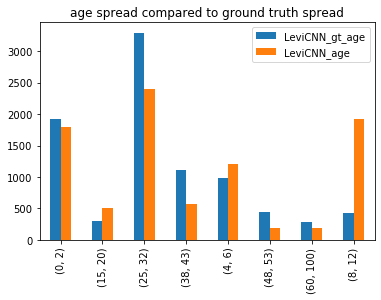

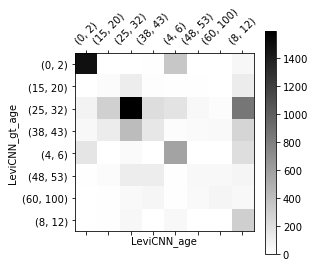

In [8]:
# Show age spread compared to ground truth age spread
s1 = df[detector_gt_prefix+value_name].value_counts()
s2 = df[detector_prefix+value_name].value_counts()
counts_df = pd.merge(s1, s2, right_index = True,left_index = True, how='outer').fillna(0)


prediction_spread = counts_df.plot(kind='bar', title=value_name+' spread compared to ground truth spread')

df_confusion = pd.crosstab(df[detector_gt_prefix+value_name], df[detector_prefix+value_name])


def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)



In [5]:
# Accuracy
match_df = df[value_name+'_match'].value_counts()
total_match_count = match_df[True] + match_df[False]
accuracy = match_df[True] / total_match_count * 1
baseline_accuracy = 1 / df[detector_prefix+value_name].value_counts().shape[0]
accuracy_over_random_chance = accuracy - baseline_accuracy
accuracy_score = round(accuracy_over_random_chance / (1 - baseline_accuracy) * 1000)

result_df = pd.DataFrame({
    'name': [detector_name],
    'dataset': ['Adience'],
    'value':[value_name],
    'bucket_count': [detector_bucket_count],
    'accuracy': [accuracy],
    'baseline_accuracy': [baseline_accuracy],
    'accuracy_over_random_chance': [accuracy_over_random_chance],
    'accuracy_score': [accuracy_score]
})

In [6]:
from pandas import Series

bucket_to_error = {
    '(0, 2)': 0,
    '(4, 6)': 1,
    '(8, 12)': 2,
    '(15, 20)': 3,
    '(25, 32)': 4,
    '(38, 43)': 5,
    '(48, 53)': 6,
    '(60, 100)': 7
}

# MAE (Mean Absolute Error)
def _error_mapping(value: str) -> int:
    return bucket_to_error[value]

df.filter([detector_prefix+value_name, detector_gt_prefix+value_name, value_name+'_match'])
df = df[df[detector_gt_prefix+value_name] != "None"]

print(df[detector_prefix+value_name].value_counts())

df[bucket_prefix+detector_prefix+value_name] = df.apply(lambda row: _error_mapping(row[detector_prefix+value_name]), axis=1)
df[bucket_prefix+detector_gt_prefix+value_name] = df.apply(lambda row: _error_mapping(row[detector_gt_prefix+value_name]), axis=1)
df['error'] = df.apply(lambda row: abs(row[bucket_prefix+detector_gt_prefix+value_name] - row[bucket_prefix+detector_prefix+value_name]), axis=1)
MAE = df['error'].sum() / df.shape[0]
normalized_MAE = MAE / (detector_bucket_count - 1)

print(f"The prediction is expected to be {MAE:0.2} buckets of the actual bucket.")
print(f"(normalized: {normalized_MAE:0.2})")

(25, 32)     2392
(8, 12)      1918
(0, 2)       1788
(4, 6)       1206
(38, 43)      566
(15, 20)      512
(48, 53)      190
(60, 100)     182
Name: LeviCNN_age, dtype: int64
The prediction is expected to be 0.94 buckets of the actual bucket.
(normalized: 0.13)


,name,dataset,value,score,accuracy_score,MAE_score,bucket_count,accuracy,baseline_accuracy,accuracy_over_random_chance,MAE,normalized_MAE
0,LeviCNN,Adience,age,1265.0,399.0,866.0,8,0.474353,0.125,0.349353,0.94037,0.134339


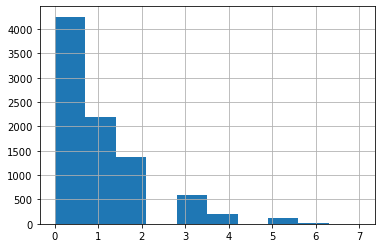

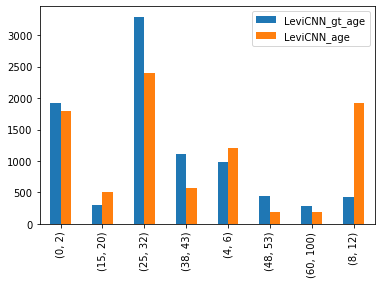

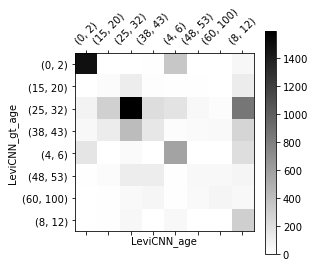

In [12]:
result_df['MAE'] = [MAE]
result_df['normalized_MAE'] = [normalized_MAE]
result_df['MAE_score'] = round((1 - normalized_MAE) * 1000)
result_df['score'] = result_df.apply(lambda row: row['accuracy_score'] + row['MAE_score'], axis=1)
result_df = result_df[['name', 'dataset', 'value', 'score', 'accuracy_score', 'MAE_score', 'bucket_count', 'accuracy', 'baseline_accuracy', 'accuracy_over_random_chance', 'MAE', 'normalized_MAE']]



absolute_error_hist = df['error'].hist()
counts_df.plot(kind='bar')
plot_confusion_matrix(df_confusion)
result_df